In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    features = dict_[b'data'].reshape((len(dict_[b'data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = dict_[b'labels']
    return (features, labels)

In [3]:
def merge(data):
    data_ = []
    for i in range(len(data[0])):
        if data[1][i] == 2:
            data_.append(data[0][i])
    return data_

### a) Using the CIFAR-10 dataset

In [5]:
data = []
data_1 = unpickle('data_batch_1');
data += merge(data_1) 
data_2 = unpickle('data_batch_2');
data += merge(data_2) 
data_3 = unpickle('data_batch_3');
data += merge(data_3) 
data_4 = unpickle('data_batch_4');
data += merge(data_4) 
data_5 = unpickle('data_batch_5');
data += merge(data_5) 
test_data = unpickle('test_batch')
data += merge(test_data) 

In [6]:
np.array(data).shape

(6000, 32, 32, 3)

### b) Using only bird images

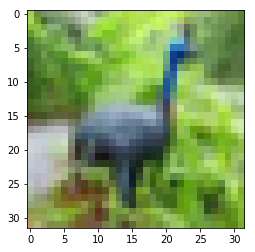

In [7]:
plt.imshow(data[0])

### c) Splitting into train and test done later

### d) Creating pixel list to find cluster centers using KMeans k = 4

In [8]:
pixel_list = np.reshape(data, (6144000, 3))

In [9]:
kmeans = KMeans(n_clusters=4)

In [10]:
kmeans.fit(pixel_list)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
kmeans.cluster_centers_

array([[109.71005442, 109.30689312,  83.26234712],
       [207.306757  , 212.53890927, 212.207985  ],
       [ 49.40417349,  50.38289826,  38.8369786 ],
       [156.8738332 , 156.31477962, 136.79228785]])

In [12]:
lab = kmeans.predict(pixel_list)

In [13]:
npl = []
Y = []
for ppp in range(len(pixel_list)):
    npl.append([int(op) for op in kmeans.cluster_centers_[lab[ppp]]])
    if lab[ppp] == 0:
        Y.append([1, 0, 0, 0])
    elif lab[ppp] == 1:
        Y.append([0, 1, 0, 0])
    elif lab[ppp] == 2:
        Y.append([0, 0, 1, 0])
    elif lab[ppp] == 3:
        Y.append([0, 0, 0, 1])

In [14]:
np.shape(npl)

(6144000, 3)

In [15]:
np.shape(Y)

(6144000, 4)

In [16]:
npl = np.reshape(npl, (6000, 32, 32, 3))
Y = np.reshape(Y, (6000, 32, 32, 4))

### e) Using skimage to create greyscale images

In [17]:
from skimage.color import rgb2grey

In [18]:
X = []
pixel_list = np.reshape(pixel_list, (6000, 32, 32, 3))
for i in range(len(pixel_list)):
    X.append(rgb2grey(pixel_list[i]).tolist())

In [19]:
X = np.reshape(X, (6000, 32, 32, 1))

In [20]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [21]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D

In [22]:
model = Sequential()

### f) Setting up the neural network layers
- 2 Convolutional layers used
- 2 MLP layers used
- 2 MaxPooling layers used
- Kernel size = 5 x 5
- Softmax is used as output layer to get probabilities

In [23]:
model.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same', input_shape = (32,32,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
model.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
model.add(Dense(32, activation='softmax'))
model.add(Dense(4, activation='softmax'))

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 32)        2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32, 32, 4)         132       
Total params: 106,340
Trainable params: 106,340
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=10)

In [27]:
y_train.shape

(5400, 32, 32, 4)

### Training for 20 epochs

In [28]:
network = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=2)

Train on 5400 samples, validate on 600 samples
Epoch 1/20
 - 41s - loss: 1.2160 - acc: 0.5020 - val_loss: 1.0969 - val_acc: 0.6922
Epoch 2/20
 - 41s - loss: 1.0266 - acc: 0.6994 - val_loss: 0.9620 - val_acc: 0.7151
Epoch 3/20
 - 41s - loss: 0.9103 - acc: 0.7204 - val_loss: 0.8654 - val_acc: 0.7239
Epoch 4/20
 - 41s - loss: 0.8307 - acc: 0.7279 - val_loss: 0.7917 - val_acc: 0.7357
Epoch 5/20
 - 41s - loss: 0.7691 - acc: 0.7350 - val_loss: 0.7431 - val_acc: 0.7360
Epoch 6/20
 - 41s - loss: 0.7184 - acc: 0.7426 - val_loss: 0.7025 - val_acc: 0.7389
Epoch 7/20
 - 41s - loss: 0.6830 - acc: 0.7452 - val_loss: 0.6633 - val_acc: 0.7474
Epoch 8/20
 - 41s - loss: 0.6589 - acc: 0.7450 - val_loss: 0.6540 - val_acc: 0.7354
Epoch 9/20
 - 41s - loss: 0.6296 - acc: 0.7502 - val_loss: 0.6229 - val_acc: 0.7465
Epoch 10/20
 - 41s - loss: 0.6104 - acc: 0.7515 - val_loss: 0.6022 - val_acc: 0.7545
Epoch 11/20
 - 41s - loss: 0.5971 - acc: 0.7506 - val_loss: 0.5909 - val_acc: 0.7457
Epoch 12/20
 - 41s - loss: 

### Computing output and comparing with test images

In [29]:
pred = model.predict(X_test)
pred = pred.reshape(614400, 4)
output_images = []
for p in range(len(pred)):
    output_images.append([int(op) for op in kmeans.cluster_centers_[np.argmax(pred[p])]])
y_test_reshaped = y_test.reshape(614400, 4)
y_test_k_color = []
for p in range(len(y_test_reshaped)):
    y_test_k_color.append([int(op) for op in kmeans.cluster_centers_[np.argmax(y_test_reshaped[p])]])
output_images = np.reshape(output_images, (600, 32, 32, 3))
y_test_k_color = np.reshape(y_test_k_color, (600, 32, 32, 3))

# Test Image (Right) vs Predicted Output (Left) for first 10 test images

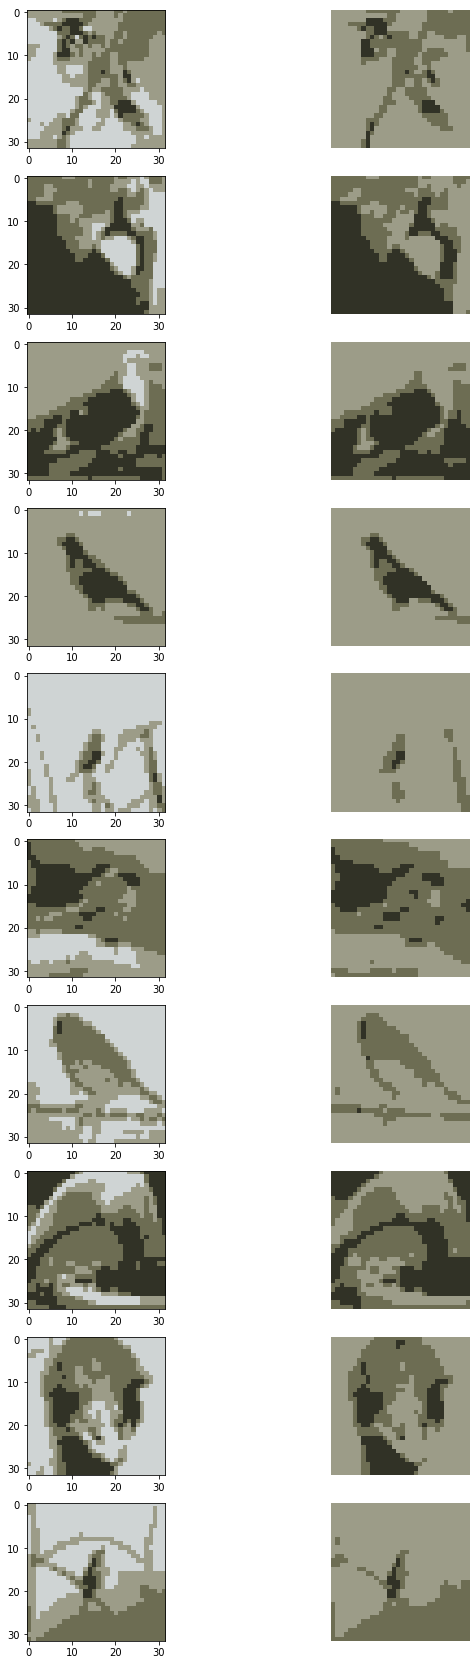

In [30]:
plt.figure(figsize=(10, 30))
subplotcount = 1
for i in range(0,10):
    plt.subplot(10, 2, subplotcount)
    subplotcount+=1
    plt.imshow(y_test_k_color[i])
    plt.subplot(10, 2, subplotcount)
    subplotcount+=1
    plt.imshow(output_images[i])
    plt.axis('off')
plt.show()

### Graph for training error/testing error vs no. of epochs

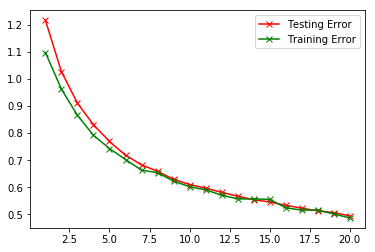

In [49]:
no_of_epochs = [int(i) for i in range(1, 21)]
plt.plot(no_of_epochs, network.history['loss'], marker = "x", color="r", label = "Testing Error")
plt.plot(no_of_epochs, network.history['val_loss'], marker = "x", color = "g", label = "Training Error")
plt.legend()

### Reporting train error, train accuracy, test error and test accuracy:

- Epoch 1/20
 - 41s - loss: 1.2160 - acc: 0.5020 - val_loss: 1.0969 - val_acc: 0.6922
- Epoch 2/20
 - 41s - loss: 1.0266 - acc: 0.6994 - val_loss: 0.9620 - val_acc: 0.7151
- Epoch 3/20
 - 41s - loss: 0.9103 - acc: 0.7204 - val_loss: 0.8654 - val_acc: 0.7239
- Epoch 4/20
 - 41s - loss: 0.8307 - acc: 0.7279 - val_loss: 0.7917 - val_acc: 0.7357
- Epoch 5/20
 - 41s - loss: 0.7691 - acc: 0.7350 - val_loss: 0.7431 - val_acc: 0.7360
- Epoch 6/20
 - 41s - loss: 0.7184 - acc: 0.7426 - val_loss: 0.7025 - val_acc: 0.7389
- Epoch 7/20
 - 41s - loss: 0.6830 - acc: 0.7452 - val_loss: 0.6633 - val_acc: 0.7474
- Epoch 8/20
 - 41s - loss: 0.6589 - acc: 0.7450 - val_loss: 0.6540 - val_acc: 0.7354
- Epoch 9/20
 - 41s - loss: 0.6296 - acc: 0.7502 - val_loss: 0.6229 - val_acc: 0.7465
- Epoch 10/20
 - 41s - loss: 0.6104 - acc: 0.7515 - val_loss: 0.6022 - val_acc: 0.7545
- Epoch 11/20
 - 41s - loss: 0.5971 - acc: 0.7506 - val_loss: 0.5909 - val_acc: 0.7457
- Epoch 12/20
 - 41s - loss: 0.5816 - acc: 0.7524 - val_loss: 0.5711 - val_acc: 0.7504
- Epoch 13/20
 - 41s - loss: 0.5673 - acc: 0.7535 - val_loss: 0.5575 - val_acc: 0.7530
- Epoch 14/20
 - 41s - loss: 0.5542 - acc: 0.7548 - val_loss: 0.5569 - val_acc: 0.7474
- Epoch 15/20
 - 41s - loss: 0.5461 - acc: 0.7533 - val_loss: 0.5561 - val_acc: 0.7296
- Epoch 16/20
 - 41s - loss: 0.5338 - acc: 0.7539 - val_loss: 0.5244 - val_acc: 0.7560
- Epoch 17/20
 - 41s - loss: 0.5232 - acc: 0.7546 - val_loss: 0.5162 - val_acc: 0.7563
- Epoch 18/20
 - 41s - loss: 0.5131 - acc: 0.7546 - val_loss: 0.5162 - val_acc: 0.7371
- Epoch 19/20
 - 41s - loss: 0.5068 - acc: 0.7524 - val_loss: 0.5017 - val_acc: 0.7446
- Epoch 20/20
 - 41s - loss: 0.4948 - acc: 0.7533 - val_loss: 0.4873 - val_acc: 0.7502